In [7]:
import sys
sys.path.append('..')
import warnings
import os
from os.path import join
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from nilearn.datasets.utils import _uncompress_file, _fetch_file
from nilearn.connectome import ConnectivityMeasure
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed

In [8]:
# DXCURREN	1. Current Diagnosis	1=NL;2=MCI;3=AD	ADNI1
from glob import glob

imid = pd.read_csv('../../connattractor/notebooks/ADNI/idaSearch_DX.csv')
order = pd.read_csv('../data_in/MIST122_relabeled.tsv', sep='\t').iloc[:, 1:]

timeseries = []
DX = []

for f in glob('../../connattractor/notebooks/ADNI/BASC/networks/*'):
    id = f.split('I')[2].split('_')[0]
    #sid = imid[imid['Image ID'] == int(id)]['Subject ID'].values.squeeze()
    dx = imid[imid['Image ID'] == int(id)]['Research Group'].values[0]
    if dx.endswith('MCI'):
        dx = 'MCI'
    #print(id, dx)
    DX.append(dx)

    ts = np.loadtxt('../../connattractor/notebooks/ADNI/BASC/networks/I' + id + '_timeseries.txt')
    #reorder columns in ts based on order['index']
    ts = ts[:, order['index'].values-1]
    ts = StandardScaler().fit_transform(ts)
    timeseries.append(ts)


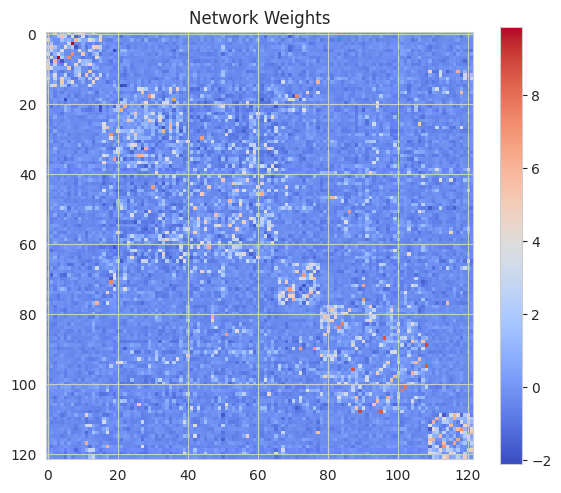

In [9]:
from connattractor import network

idxs = np.where((np.array(DX)=="MCI") | (np.array(DX)=="AD"))[0]

connections = ConnectivityMeasure(kind='partial correlation', vectorize=True, discard_diagonal=True)
tmp = [timeseries[i] for i in idxs]
connections.fit_transform(tmp)

mtx = connections.mean_
hopnet = network.Hopfield(mtx, scale=True)
hopnet.plot_weights()

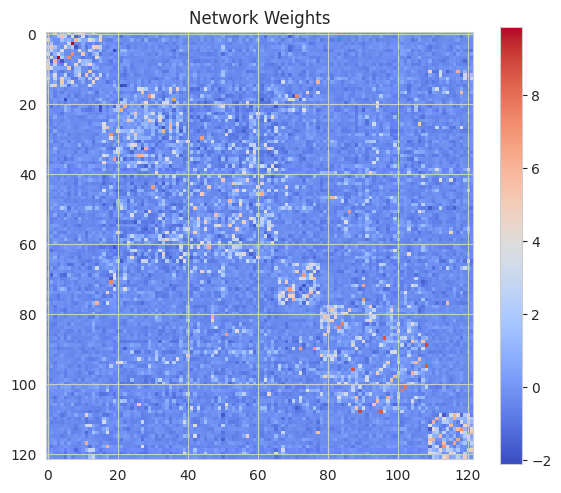

In [3]:
from connattractor import network

idxs = np.where((np.array(DX)=="MCI") | (np.array(DX)=="AD"))[0]

connections = ConnectivityMeasure(kind='partial correlation', vectorize=True, discard_diagonal=True)
tmp = [timeseries[i] for i in idxs]
connections.fit_transform(tmp)

mtx = connections.mean_
hopnet = network.Hopfield(mtx, scale=True)
hopnet.plot_weights()

In [8]:
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
import connattractor.statedynamics as sd

_threshold_ = 0

hopnet.beta = 0.044 # 4 states for group level connectome

_standardize_ts = True
_standardize_act = True

_TR_ = 3.0 #sec

# statedict is now group-level
statedict = []
meanacts = []
statelabels = []

for ts in tqdm(timeseries):
    # standardize timeseries
    ts = pd.DataFrame(data=ts)

    columns = ts.columns
    if _standardize_ts:
        ts = pd.DataFrame(StandardScaler().fit_transform(ts), columns=columns)

    # get all subject-level attractor states activations:
    attractor_states = sd.get_attractors_per_timesample(ts, hopnet)

    statelabel, statedict = sd.label_att_states(attractor_states, statedict)

    meanacts.append(sd.mean_state_activation(statedict, statelabel, ts, _standardize_act))
    statelabels.append(statelabel)
    
print('number of states:', len(statedict))

  0%|          | 0/136 [00:00<?, ?it/s]

number of states: 4


In [9]:
from connattractor.statedynamics import StateDynamics

statecontainer = StateDynamics()
statecontainer.read_meanactivation(meanacts)

## Stats

In [10]:
idx_ctr = np.where(np.array(DX)=="MCI")[0]
idx_path = np.where(np.array(DX)=="AD")[0]

In [11]:
labels_ctr = [arr for i, arr in enumerate(statelabels) if i in idx_ctr]
labels_path = [arr for i, arr in enumerate(statelabels) if i in idx_path]

In [12]:
# sort the activations according to group and state
act_ctr = {key: [] for key in range(len(statedict))}
act_path = {key: [] for key in range(len(statedict))}

for idx, sub_ts in enumerate(timeseries):
    if idx in idx_ctr:
        for idx_label, label in enumerate(statelabels[idx]):
            act_ctr[label].append(sub_ts[idx_label])
    elif idx in idx_path:
        for idx_label, label in enumerate(statelabels[idx]):
            act_path[label].append(sub_ts[idx_label])
    else:
        print(idx)
    

44
64
131


In [13]:
# calc mean acts
mean_act_ctr = {}
mean_act_path = {}

for state, acts in act_ctr.items():
    mean_act_ctr[state] = np.mean(acts, axis=0)
    
for state, acts in act_path.items():
    mean_act_path[state] = np.mean(acts, axis=0)

In [14]:
def workhorse(seed):
    random = np.random.default_rng(int(seed))
    timeseries_shuffled = timeseries.copy()
    timeseries_shuffled = random.permutation(timeseries_shuffled)
    
    for idx, sub_ts in enumerate(timeseries_shuffled):
        if idx in idx_ctr:
            for idx_label, label in enumerate(statelabels[idx]):
                act_ctr[label].append(sub_ts[idx_label])
        elif idx in idx_path:
            for idx_label, label in enumerate(statelabels[idx]):
                act_path[label].append(sub_ts[idx_label])
                  
    mean_act_diff = {}

    for state, acts in act_ctr.items():
        mean_act_diff[state] = np.mean(acts, axis=0) - np.mean(act_path[state], axis = 0)
        
    return mean_act_diff

In [15]:
from joblib import Parallel, delayed

n_perm = 1000

random = np.random.default_rng(42)
seeds = random.integers(0, np.iinfo(int).max, n_perm)

results = Parallel(n_jobs=-1)(delayed(workhorse)(seed) for seed in seeds)

In [16]:
# unpack the results
states_null_dist = {}

for idx, res in enumerate(results):
    if idx == 0:
        for state, acts in res.items():
            states_null_dist[state] = acts
            
    else:
        for state, acts in res.items():
            states_null_dist[state] = np.vstack([states_null_dist[state], acts]) 

In [17]:
# actual stats
alpha = 5
alpha_bnfr = 0.0102 # 5 /( 4 states and 122 regions)

sig_differences = {key: [] for key in range(len(statedict))}
act_differences = {key: [] for key in range(len(statedict))}

for state, null_dist in states_null_dist.items():
    actual_difference = mean_act_ctr[state] - mean_act_path[state]
    sig_difference = actual_difference.copy()
    for reg in range(np.shape(null_dist)[1]):
        alpha_threshold = np.percentile(null_dist[:, reg], 100 - alpha_bnfr)
        # if it doesnt pass the threshold, set to 0
        if actual_difference[reg] < alpha_threshold:
            sig_difference[reg] = 0
    sig_differences[state] = sig_difference
    act_differences[state] = actual_difference

/home/renglert/PycharmProjects/connattractor_pub/venv/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


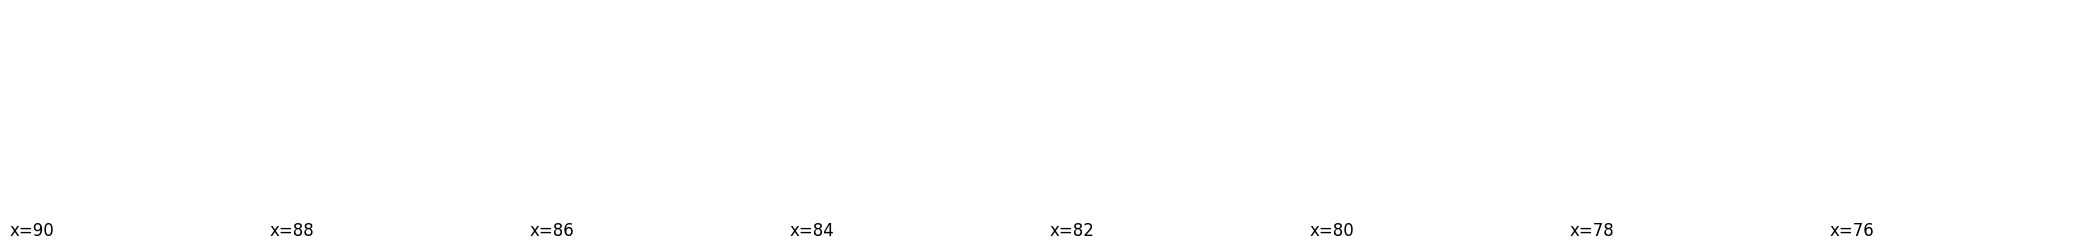

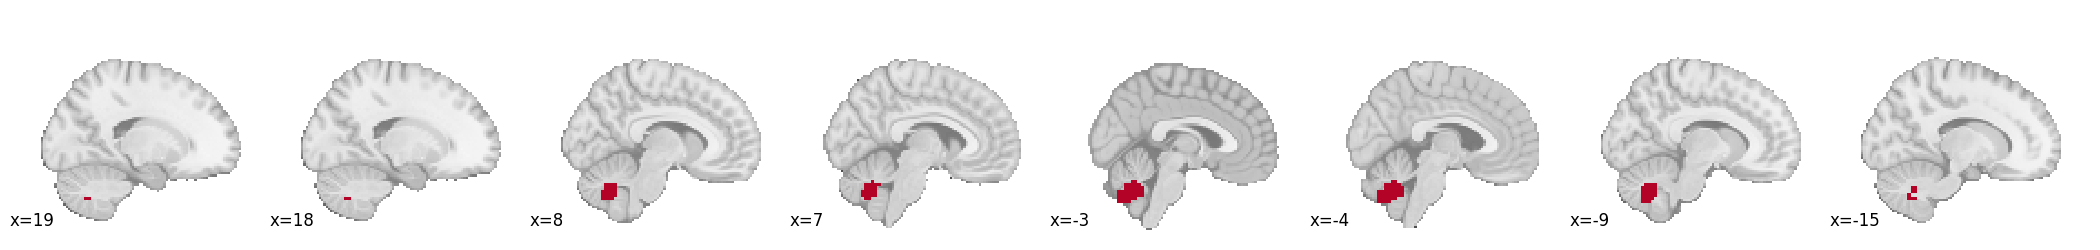

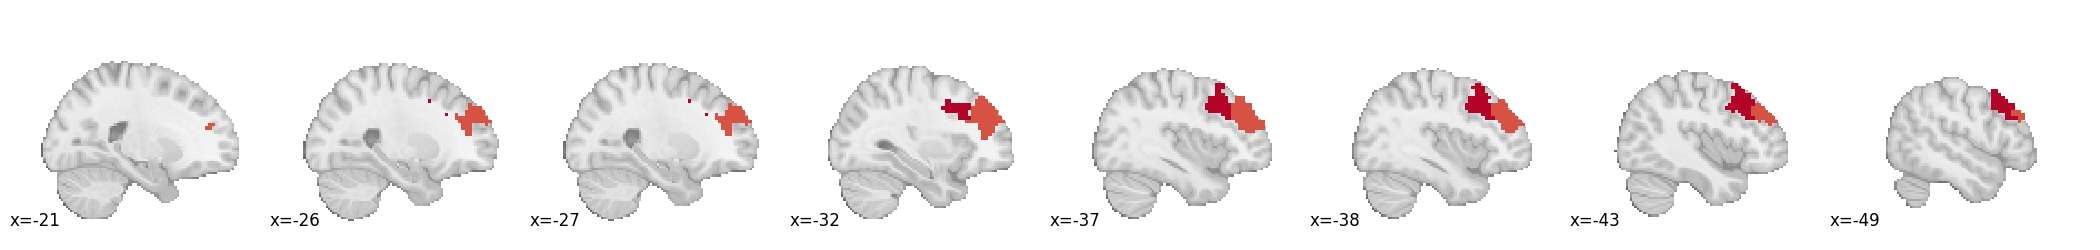

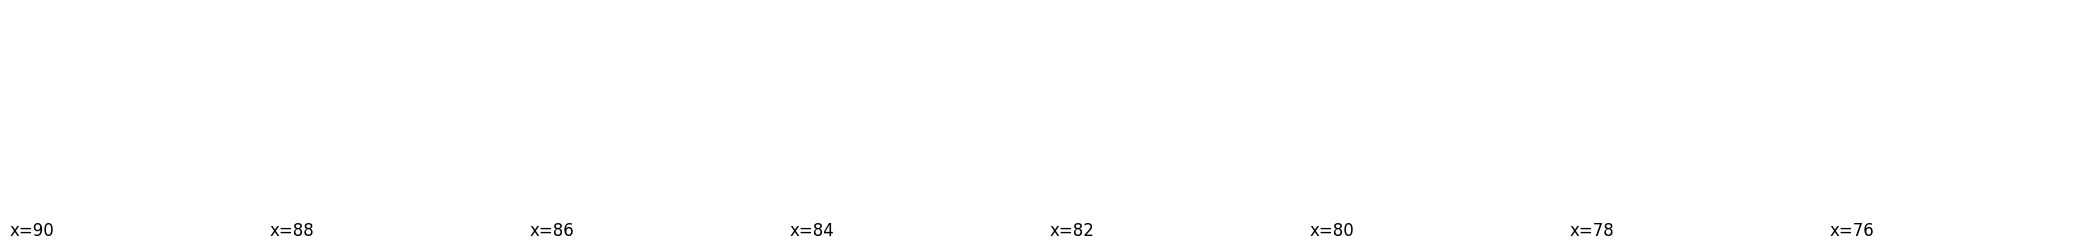

In [18]:
import matplotlib.cm as cm
import nilearn.plotting as plotting
# manually select slices to plot sig meanacts

roi_kwargs = {
    'display_mode': 'x',
    'cmap': cm.coolwarm,
    'cut_coords': (8),
    'colorbar': False,
    'threshold': 0,
    'draw_cross': False
}

for state in range(len(statedict)):
    plotting.plot_stat_map(network.State(sig_differences[state]).to_Nifti1Image(), **roi_kwargs)
    plt.show()

In [19]:
state_slices = {
    0: [1],
    1: [-3],
    2: [-37],
    3: [1]
}

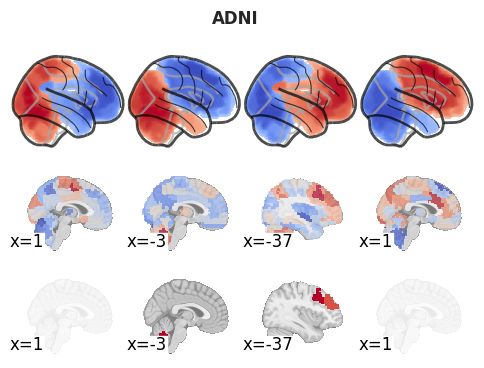

In [20]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
import nilearn.plotting as plotting


glassbrains_kwargs = {
            'display_mode': 'r',
            'colorbar': False,
            'plot_abs': False,
            'cmap': cm.coolwarm,
            }

roi_kwargs = {
    'display_mode': 'x',
    'cmap': cm.coolwarm,
    'colorbar': False,
    'threshold': 0,
    'draw_cross': False
}

roi_kwargs_empty = {
    'display_mode': 'x',
    'cmap': 'light-gray',
    'cut_coords': [1],
    'colorbar': False,
    'threshold': 0,
    'draw_cross': False,
    'alpha': 0.2,
    'dim': 10
}


fig, axes = plt.subplots(3, 4, figsize=(6, 4), gridspec_kw = {'wspace':0, 'hspace':0})

for state in range(len(statedict)):
    network.State(statedict[state]).plot(**glassbrains_kwargs, axes=axes[0, state])

    #network.State(actual_difference).plot(**glassbrains_kwargs, axes=axes[1, state])
    plotting.plot_roi(network.State(act_differences[state]).to_Nifti1Image(), 
                                      cut_coords=state_slices[state], **roi_kwargs, axes=axes[1, state])
    #network.State(sig_difference).plot(**glassbrains_kwargs, axes=axes[2, state])
    if any(reg != 0 for reg in sig_differences[state]):
        plotting.plot_stat_map(network.State(sig_differences[state]).to_Nifti1Image(), 
                               cut_coords=state_slices[state], **roi_kwargs, axes=axes[2, state])
    else:
        plotting.plot_stat_map(network.State(np.zeros(122)).to_Nifti1Image(), **roi_kwargs_empty, axes=axes[2, state])


children = axes[0, state].get_children()
        
fig.suptitle("ADNI", fontsize=12, fontweight='bold')

plt.subplots_adjust(top=0.8)
plt.savefig('../data_out/fig/ADNI_state_analysis.pdf')
plt.show()